In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Concatenate, BatchNormalization, DepthwiseConv2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Lambda, Reshape, Layer, Activation, Add, Multiply, concatenate
from tensorflow.keras import layers 
from math import ceil
import numpy as np

In [34]:
class AE(Model):
  def __init__(self):
    super(AE, self).__init__()
    self.code = Dense(8,activation = 'relu')
  def build(self, input_shape):
    self.dense1 = Dense(input_shape[-1], activation = 'relu')
    self.dense2 = Dense(input_shape[-1], activation = 'relu')
  def call(self, inputs):    
    d1 = self.dense1(inputs)
    code = self.code(d1)
    d2 = self.dense2(code)    
    return d2

In [35]:
class CBAM(Model):
  def __init__(self):
    super(CBAM, self).__init__()          
    self.relu = Activation('relu') 
    self.AvgPool = AveragePooling2D(pool_size=(2, 2),strides=(1, 1), padding='same')
    self.MaxPool = MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='same')    
    self.conv = Conv2D(1, (7, 7), strides=(1, 1), padding='same', activation='sigmoid')
    self.AE = AE()

  def call(self, inputs):
    #for channel attention    
    GAP = GlobalAveragePooling2D()(inputs)    
    GMP = GlobalMaxPooling2D()(inputs)    
    AE1 = self.AE(GAP)
    AE2 = self.AE(GMP)
    add = Add()([AE1, AE2])
    channel_attention = self.relu(add)
    multiply1 = Multiply()([inputs, channel_attention])
    #for spatial attention
    GAP_f = self.AvgPool(multiply1)
    GMP_f = self.MaxPool(multiply1)
    concat = concatenate([GAP_f, GMP_f])   
    spatial_attention = self.conv(concat)
    output = Multiply()([multiply1, spatial_attention])    
    return output

In [36]:
def VGG16():
  input_shape = (32, 32, 3)
  model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    CBAM(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')
    ])
  return model

In [37]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [38]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [39]:
IMAGE_SIZE = 32
batch_size = 64
epoch_num = 70
AUTO = tf.data.AUTOTUNE

In [40]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
) 

In [41]:
#change_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
#adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [42]:
model = VGG16()
model.build(input_shape = (1, 32, 32, 3))
model.summary()
checkpoint = tf.train.Checkpoint(myModel=model)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(train_ds_simple,
          batch_size=batch_size,
          epochs=100,          
          validation_data=test_ds_simple)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 256)        

In [43]:
model.metrics_names

['loss', 'accuracy']

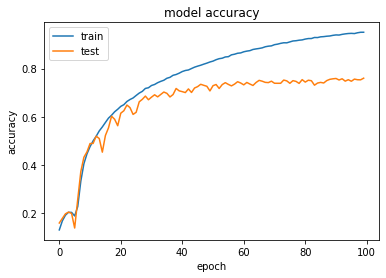

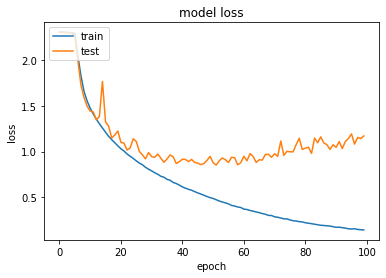

In [44]:
# summarize history for accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
checkpoint.save('/content/drive/MyDrive/Colab Notebooks/2021/paper/gostnet/weight/VGG16/model.ckpt')

NameError: ignored